In [1]:
import pandas as pd 
import numpy as np 
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow 
import tensorflow as tf

In [2]:
#Pre-processing the input data using ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
IMG_SIZE = 180
DIM = (IMG_SIZE, IMG_SIZE)
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"
WORK_DIR="mri-image-dataset/Alzheimer_s Dataset/train"
work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 5121 images belonging to 4 classes.


In [3]:
#Splitting the dataset into images and corresponding labels
train_data, train_labels = train_data_gen.next()

In [4]:
#Performing image augmentation to balance out the minority classes in the dataset
from imblearn.over_sampling import SMOTE
sm_obj = SMOTE(random_state=56)

train_data, train_labels = sm_obj.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(10240, 180, 180, 3) (10240, 4)


In [5]:
#Spltting the dataset into training, testing and validation
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=56)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=56)

In [15]:
#Importing the pre-trained ResNet50V2 from keras
from tensorflow.keras.applications import ResNet50V2
resnet_model = ResNet50V2(input_shape=(180, 180, 3), include_top=False, weights="imagenet")

In [16]:
#Freezing the weights of the pre-trained model
for layer in resnet_model.layers:
    layer.trainable=False

In [19]:
#Adding additional layers to the base model so that it classifies the images into 4 classes
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D
my_resnet_model = Sequential([
        resnet_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')        
    ])

In [20]:
#Compiling the model
my_resnet_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=["accuracy"])

In [21]:
#Training/fitting the model using the training dataset
hist = my_resnet_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=20)

Epoch 1/20
205/205 [==============================] - 543s 3s/step - loss: 1.3004 - accuracy: 0.4577 - val_loss: 0.7559 - val_accuracy: 0.6724
Epoch 2/20
205/205 [==============================] - 557s 3s/step - loss: 0.8625 - accuracy: 0.6086 - val_loss: 0.6510 - val_accuracy: 0.7114
Epoch 3/20
205/205 [==============================] - 542s 3s/step - loss: 0.7428 - accuracy: 0.6644 - val_loss: 0.5778 - val_accuracy: 0.7383
Epoch 4/20
205/205 [==============================] - 524s 3s/step - loss: 0.6819 - accuracy: 0.7084 - val_loss: 0.5279 - val_accuracy: 0.7688
Epoch 5/20
205/205 [==============================] - 558s 3s/step - loss: 0.6286 - accuracy: 0.7363 - val_loss: 0.4952 - val_accuracy: 0.7877
Epoch 6/20
205/205 [==============================] - 534s 3s/step - loss: 0.5680 - accuracy: 0.7612 - val_loss: 0.4744 - val_accuracy: 0.7871
Epoch 7/20
205/205 [==============================] - 562s 3s/step - loss: 0.5444 - accuracy: 0.7751 - val_loss: 0.4379 - val_accuracy: 0.8151

In [23]:
#Evaluating the model's performance using testing dataset
loss, accuracy = my_resnet_model.evaluate(test_data,test_labels)

64/64 [==============================] - 240s 4s/step - loss: 0.3013 - accuracy: 0.8892


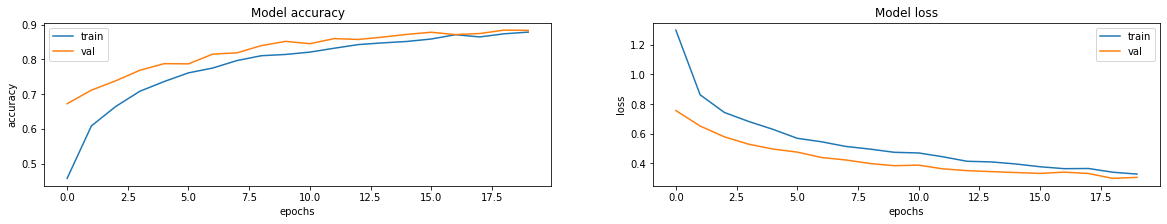

In [26]:
#Plotting the progress of training and accuracy
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [27]:
#Saving the model
my_resnet_model.save("model_resnet_augmented_1.h5")

In [69]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('model_resnet_augmented_1.h5')

In [ ]:
classnames = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

In [70]:
predictions = model.predict(test_data)

64/64 [==============================] - 142s 2s/step


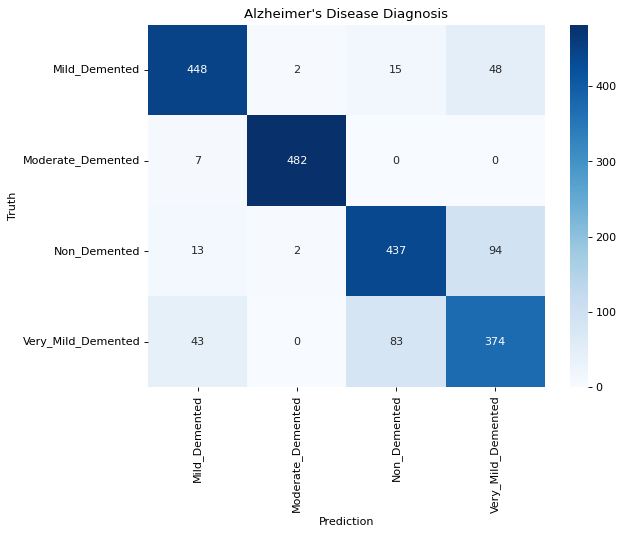

In [19]:
#Confusion matrix for resnet basic model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

pred_ls = np.argmax(predictions, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Blues', annot=True, fmt='d', xticklabels= classnames,
                yticklabels=classnames)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

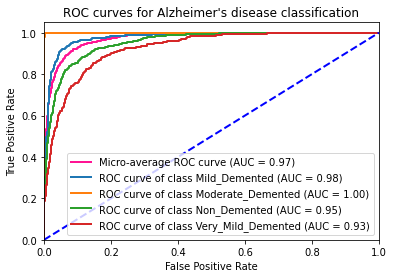

In [71]:
#ROC curve for resnet basic model
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], color="deeppink", lw=lw, label="Micro-average ROC curve (AUC = {0:0.2f})".format(roc_auc["micro"]))
for i in range(4):
    plt.plot(fpr[i], tpr[i], lw=lw, label="ROC curve of class {0} (AUC = {1:0.2f})".format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], color="b", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves for Alzheimer's disease classification")
plt.legend(loc="lower right")
plt.show()

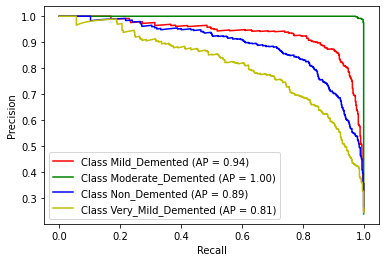

In [72]:
#Precision-recall curve for resnet basic model
from sklearn.metrics import precision_recall_curve, average_precision_score
avg_precisions = []
for i in range(4):
    avg_precisions.append(average_precision_score(test_labels[:, i], predictions[:, i]))
precisions = []
recalls = []
for i in range(4):
    precision, recall, _ = precision_recall_curve(test_labels[:, i], predictions[:, i])
    precisions.append(precision)
    recalls.append(recall)
fig, ax = plt.subplots()
colors = ["r", "g", "b", "y"]
for i in range(len(test_labels[0])):
    ax.plot(recalls[i], precisions[i], label="Class {} (AP = {:.2f})".format(classnames[i], avg_precisions[i]), color=colors[i])
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()
plt.show()


In [28]:
#Importing the pre-trained DenseNet121 from keras
from tensorflow.keras.applications import DenseNet121
densenet_model = DenseNet121(input_shape=(180, 180, 3), include_top=False, weights="imagenet")

29084464/29084464 [==============================] - 10s 0us/step


In [29]:
#Freezing the weights of the pre-trained model
for layer in densenet_model.layers:
    layer.trainable=False

In [30]:
#Adding additional layers to the base model so that it classifies the images into 4 classes
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D
my_densenet_model = Sequential([
        densenet_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')        
    ])

In [31]:
#Compiling the model
my_densenet_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=["accuracy"])

In [32]:
#Training the model for 10 epochs
hist_2 = my_densenet_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=10)

Epoch 1/10
205/205 [==============================] - 1030s 5s/step - loss: 1.3146 - accuracy: 0.4450 - val_loss: 0.7841 - val_accuracy: 0.6577
Epoch 2/10
205/205 [==============================] - 990s 5s/step - loss: 0.8759 - accuracy: 0.6090 - val_loss: 0.6462 - val_accuracy: 0.7059
Epoch 3/10
205/205 [==============================] - 1039s 5s/step - loss: 0.7739 - accuracy: 0.6487 - val_loss: 0.5872 - val_accuracy: 0.7297
Epoch 4/10
205/205 [==============================] - 1006s 5s/step - loss: 0.7086 - accuracy: 0.6841 - val_loss: 0.5525 - val_accuracy: 0.7505
Epoch 5/10
205/205 [==============================] - 992s 5s/step - loss: 0.6850 - accuracy: 0.7053 - val_loss: 0.5329 - val_accuracy: 0.7590
Epoch 6/10
205/205 [==============================] - 749s 4s/step - loss: 0.6445 - accuracy: 0.7232 - val_loss: 0.4889 - val_accuracy: 0.7889
Epoch 7/10
205/205 [==============================] - 570s 3s/step - loss: 0.6045 - accuracy: 0.7430 - val_loss: 0.4818 - val_accuracy: 0.8

In [33]:
#Evaluating
loss, accuracy = my_densenet_model.evaluate(test_data,test_labels)

64/64 [==============================] - 142s 2s/step - loss: 0.3839 - accuracy: 0.8462


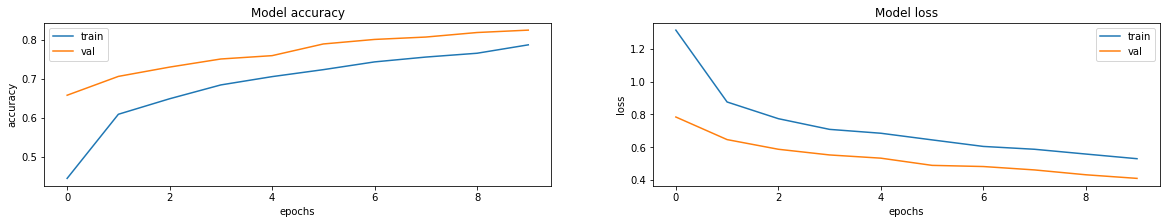

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist_2.history[met])
    ax[i].plot(hist_2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [35]:
my_densenet_model.save("model_densenet_augmented_1.h5")

In [6]:
from tensorflow.keras.models import load_model

my_densenet_model = load_model('model_densenet_augmented_1.h5')

In [7]:
#Training the model for another 10 epochs
hist_2 = my_densenet_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=10)

Epoch 1/10
205/205 [==============================] - 697s 3s/step - loss: 0.5747 - accuracy: 0.7702 - val_loss: 0.4112 - val_accuracy: 0.8304
Epoch 2/10
205/205 [==============================] - 623s 3s/step - loss: 0.5468 - accuracy: 0.7801 - val_loss: 0.3921 - val_accuracy: 0.8395
Epoch 3/10
205/205 [==============================] - 599s 3s/step - loss: 0.5184 - accuracy: 0.7905 - val_loss: 0.3794 - val_accuracy: 0.8444
Epoch 4/10
205/205 [==============================] - 615s 3s/step - loss: 0.4885 - accuracy: 0.8067 - val_loss: 0.3634 - val_accuracy: 0.8517
Epoch 5/10
205/205 [==============================] - 611s 3s/step - loss: 0.4841 - accuracy: 0.8111 - val_loss: 0.3540 - val_accuracy: 0.8523
Epoch 6/10
205/205 [==============================] - 600s 3s/step - loss: 0.4733 - accuracy: 0.8175 - val_loss: 0.3372 - val_accuracy: 0.8603
Epoch 7/10
205/205 [==============================] - 610s 3s/step - loss: 0.4374 - accuracy: 0.8315 - val_loss: 0.3206 - val_accuracy: 0.8633

In [8]:
loss, accuracy = my_densenet_model.evaluate(test_data,test_labels)

64/64 [==============================] - 141s 2s/step - loss: 0.2997 - accuracy: 0.8838


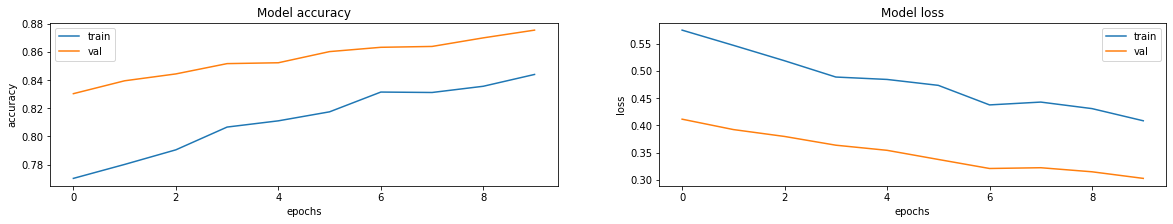

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist_2.history[met])
    ax[i].plot(hist_2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [10]:
my_densenet_model.save("model_densenet_augmented_2.h5")

In [58]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('model_densenet_augmented_2.h5')

In [59]:
predictions = model.predict(test_data)

64/64 [==============================] - 153s 2s/step


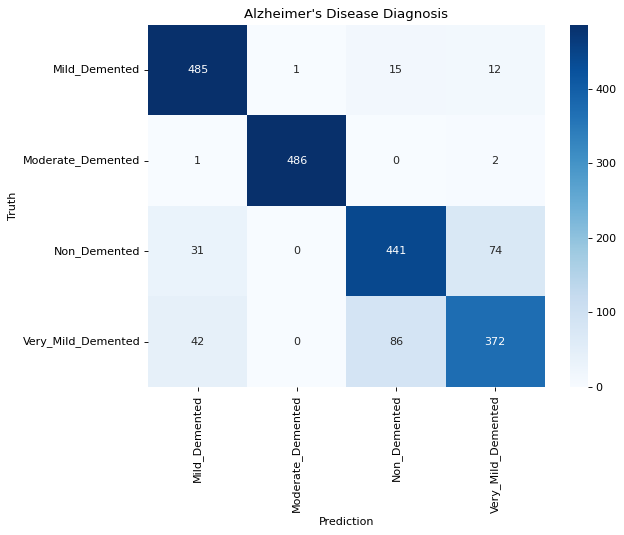

In [32]:
#Confusion matrix for densenet basic model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
pred_ls = np.argmax(predictions, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Blues', annot=True, fmt='d', xticklabels= classnames,
                yticklabels=classnames)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

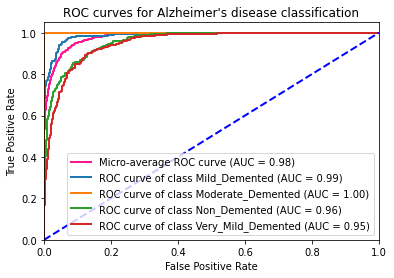

In [67]:
#ROC curve for densenet basic model 
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], color="deeppink", lw=lw, label="Micro-average ROC curve (AUC = {0:0.2f})".format(roc_auc["micro"]))
for i in range(4):
    plt.plot(fpr[i], tpr[i], lw=lw, label="ROC curve of class {0} (AUC = {1:0.2f})".format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], color="b", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves for Alzheimer's disease classification")
plt.legend(loc="lower right")
plt.show()

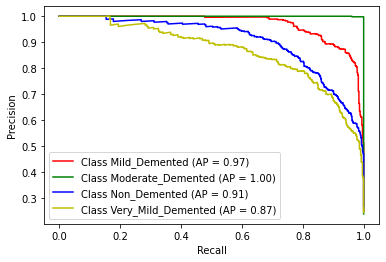

In [68]:
#Precision-recall curve for densenet basic model
from sklearn.metrics import precision_recall_curve, average_precision_score
avg_precisions = []
for i in range(4):
    avg_precisions.append(average_precision_score(test_labels[:, i], predictions[:, i]))
precisions = []
recalls = []
for i in range(4):
    precision, recall, _ = precision_recall_curve(test_labels[:, i], predictions[:, i])
    precisions.append(precision)
    recalls.append(recall)
fig, ax = plt.subplots()
colors = ["r", "g", "b", "y"]
for i in range(len(test_labels[0])):
    ax.plot(recalls[i], precisions[i], label="Class {} (AP = {:.2f})".format(classnames[i], avg_precisions[i]), color=colors[i])
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()
plt.show()


In [12]:
#Importing the pre-trained Xception model from keras
from tensorflow.keras.applications import Xception
xception_model = Xception(input_shape=(180, 180, 3), include_top=False, weights="imagenet")

83683744/83683744 [==============================] - 27s 0us/step


In [13]:
#Freezing the weights of the pre-trained model
for layer in xception_model.layers:
    layer.trainable=False

In [14]:
#Adding aditional needed layers
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D
my_xception_model = Sequential([
        xception_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')        
    ])

In [15]:
#Compile the model
my_xception_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=["accuracy"])

In [16]:
#Training the model for 8 epochs
hist = my_xception_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=20)

Epoch 1/20
205/205 [==============================] - 630s 3s/step - loss: 1.2916 - accuracy: 0.4674 - val_loss: 0.8772 - val_accuracy: 0.6461
Epoch 2/20
205/205 [==============================] - 609s 3s/step - loss: 0.9137 - accuracy: 0.5883 - val_loss: 0.6865 - val_accuracy: 0.6937
Epoch 3/20
205/205 [==============================] - 620s 3s/step - loss: 0.7803 - accuracy: 0.6464 - val_loss: 0.6310 - val_accuracy: 0.7114
Epoch 4/20
205/205 [==============================] - 621s 3s/step - loss: 0.7247 - accuracy: 0.6656 - val_loss: 0.5930 - val_accuracy: 0.7236
Epoch 5/20
205/205 [==============================] - 1045s 5s/step - loss: 0.6817 - accuracy: 0.6902 - val_loss: 0.5649 - val_accuracy: 0.7389
Epoch 6/20
205/205 [==============================] - 1077s 5s/step - loss: 0.6386 - accuracy: 0.7114 - val_loss: 0.5457 - val_accuracy: 0.7566
Epoch 7/20
205/205 [==============================] - 915s 4s/step - loss: 0.6220 - accuracy: 0.7322 - val_loss: 0.5139 - val_accuracy: 0.77

KeyboardInterrupt: 

In [17]:
loss, accuracy = my_xception_model.evaluate(test_data,test_labels)

64/64 [==============================] - 262s 4s/step - loss: 0.5264 - accuracy: 0.7612


NameError: name 'hist' is not defined

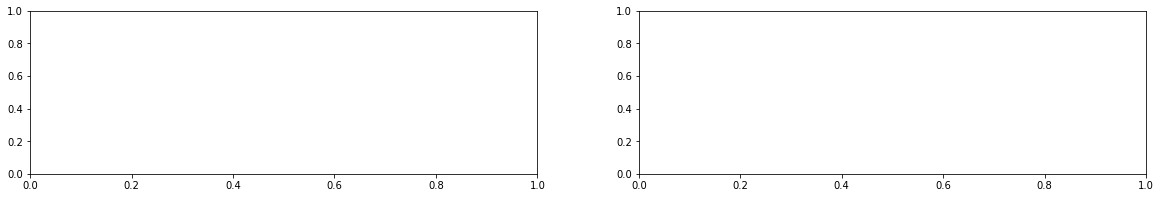

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [20]:
my_xception_model.save("model_xception_augmented_1.h5")

In [21]:
hist_2 = my_xception_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=12)

Epoch 1/12
205/205 [==============================] - 645s 3s/step - loss: 0.5856 - accuracy: 0.7468 - val_loss: 0.5011 - val_accuracy: 0.7700
Epoch 2/12
205/205 [==============================] - 643s 3s/step - loss: 0.5540 - accuracy: 0.7641 - val_loss: 0.4739 - val_accuracy: 0.7834
Epoch 3/12
205/205 [==============================] - 644s 3s/step - loss: 0.5311 - accuracy: 0.7760 - val_loss: 0.4598 - val_accuracy: 0.8029
Epoch 4/12
205/205 [==============================] - 757s 4s/step - loss: 0.5297 - accuracy: 0.7798 - val_loss: 0.4542 - val_accuracy: 0.7987
Epoch 5/12
205/205 [==============================] - 689s 3s/step - loss: 0.4907 - accuracy: 0.8013 - val_loss: 0.4548 - val_accuracy: 0.8017
Epoch 6/12
205/205 [==============================] - 686s 3s/step - loss: 0.4769 - accuracy: 0.8108 - val_loss: 0.4409 - val_accuracy: 0.7987
Epoch 7/12
205/205 [==============================] - 618s 3s/step - loss: 0.4521 - accuracy: 0.8167 - val_loss: 0.4260 - val_accuracy: 0.8078

In [22]:
loss, accuracy = my_xception_model.evaluate(test_data,test_labels)

64/64 [==============================] - 155s 2s/step - loss: 0.3947 - accuracy: 0.8320


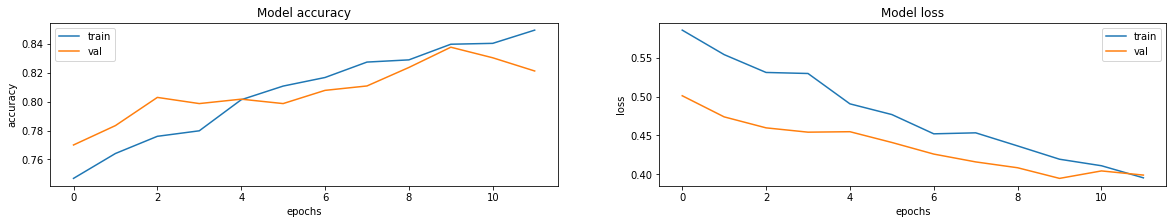

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist_2.history[met])
    ax[i].plot(hist_2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [32]:
my_xception_model.save("model_xception_augmented_2.h5")

In [73]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('model_xception_augmented_2.h5')

In [74]:
predictions = model.predict(test_data)

64/64 [==============================] - 149s 2s/step


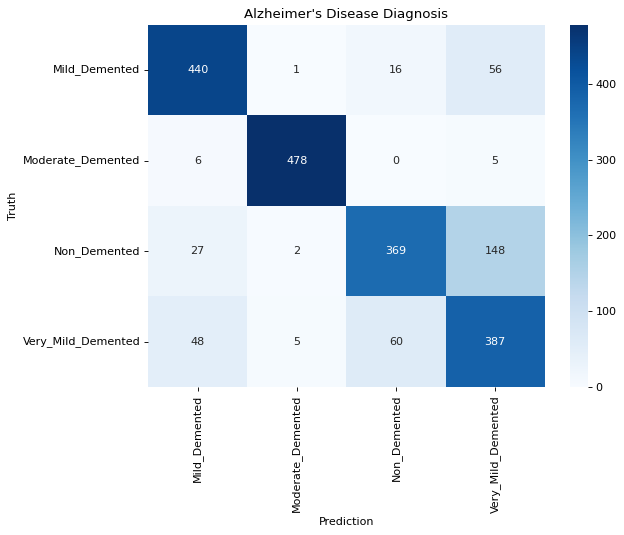

In [35]:
#Confusion matrix for Xception basic model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

pred_ls = np.argmax(predictions, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Blues', annot=True, fmt='d', xticklabels= classnames,
                yticklabels=classnames)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

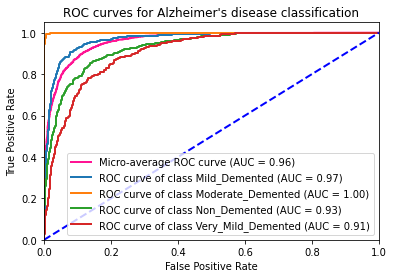

In [75]:
#ROC curve for Xception basic model
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], color="deeppink", lw=lw, label="Micro-average ROC curve (AUC = {0:0.2f})".format(roc_auc["micro"]))
for i in range(4):
    plt.plot(fpr[i], tpr[i], lw=lw, label="ROC curve of class {0} (AUC = {1:0.2f})".format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], color="b", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves for Alzheimer's disease classification")
plt.legend(loc="lower right")
plt.show()

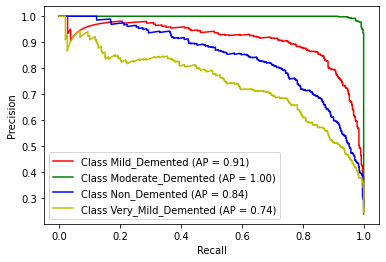

In [76]:
#Precisin-recall curve for Xception basic model
from sklearn.metrics import precision_recall_curve, average_precision_score
avg_precisions = []
for i in range(4):
    avg_precisions.append(average_precision_score(test_labels[:, i], predictions[:, i]))
precisions = []
recalls = []
for i in range(4):
    precision, recall, _ = precision_recall_curve(test_labels[:, i], predictions[:, i])
    precisions.append(precision)
    recalls.append(recall)
fig, ax = plt.subplots()
colors = ["r", "g", "b", "y"]
for i in range(len(test_labels[0])):
    ax.plot(recalls[i], precisions[i], label="Class {} (AP = {:.2f})".format(classnames[i], avg_precisions[i]), color=colors[i])
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()
plt.show()


In [25]:
#Importing the pretrained MobileNetV2 from keras
from tensorflow.keras.applications import MobileNetV2
mobilenet_model = MobileNetV2(input_shape=[180, 180, 3], include_top=False, weights="imagenet")

In [26]:
#Freezing the weights of the pre-trained model
for layer in mobilenet_model.layers:
    layer.trainable=False

In [27]:
#Adding necessary layers
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D
my_mobilenet_model = Sequential([
        mobilenet_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')        
    ])

In [28]:
#Compliling the model
my_mobilenet_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=["accuracy"])

In [29]:
#Training the model for 20 epochs
hist = my_mobilenet_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=20)

Epoch 1/20
205/205 [==============================] - 182s 842ms/step - loss: 1.3783 - accuracy: 0.4222 - val_loss: 0.7823 - val_accuracy: 0.6486
Epoch 2/20
205/205 [==============================] - 158s 772ms/step - loss: 0.8757 - accuracy: 0.6028 - val_loss: 0.6314 - val_accuracy: 0.7084
Epoch 3/20
205/205 [==============================] - 157s 764ms/step - loss: 0.7514 - accuracy: 0.6530 - val_loss: 0.5806 - val_accuracy: 0.7254
Epoch 4/20
205/205 [==============================] - 158s 770ms/step - loss: 0.6736 - accuracy: 0.7003 - val_loss: 0.5386 - val_accuracy: 0.7682
Epoch 5/20
205/205 [==============================] - 162s 789ms/step - loss: 0.6347 - accuracy: 0.7239 - val_loss: 0.5080 - val_accuracy: 0.7761
Epoch 6/20
205/205 [==============================] - 183s 892ms/step - loss: 0.6033 - accuracy: 0.7459 - val_loss: 0.4781 - val_accuracy: 0.7919
Epoch 7/20
205/205 [==============================] - 180s 877ms/step - loss: 0.5622 - accuracy: 0.7633 - val_loss: 0.4791 -

In [30]:
loss, accuracy = my_mobilenet_model.evaluate(test_data,test_labels)

64/64 [==============================] - 44s 687ms/step - loss: 0.3157 - accuracy: 0.8779


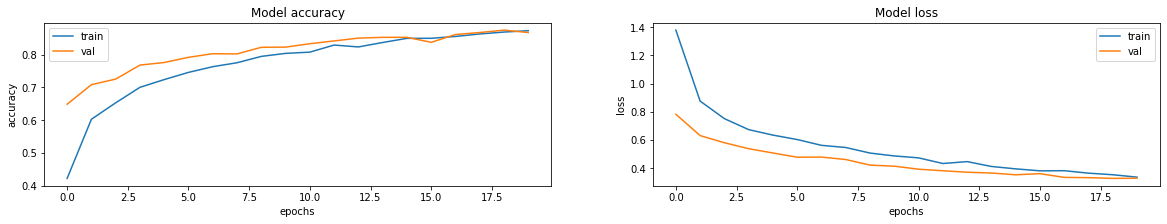

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [33]:
my_mobilenet_model.save("model_mobilenet_augmented_1.h5")

In [77]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('model_mobilenet_augmented_1.h5')

In [78]:
predictions = model.predict(test_data)

64/64 [==============================] - 39s 592ms/step


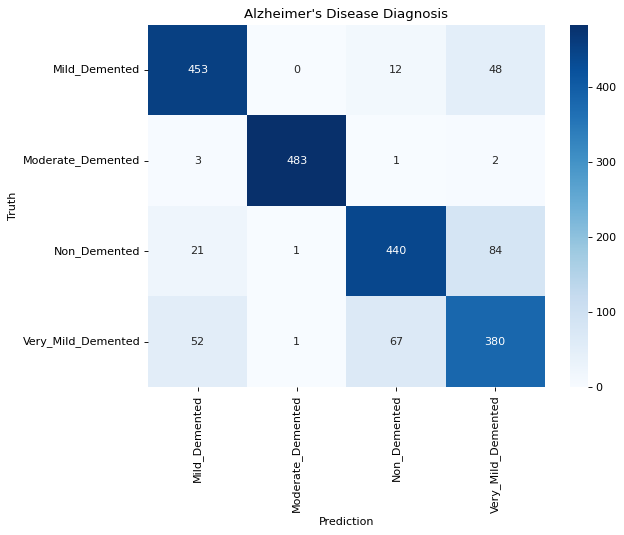

In [38]:
#Confusion matrix for mobilenet basic model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

pred_ls = np.argmax(predictions, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Blues', annot=True, fmt='d', xticklabels= classnames,
                yticklabels=classnames)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

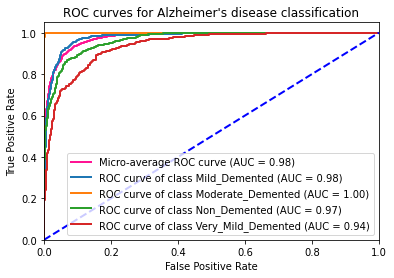

In [79]:
#ROC curve for mobilenet basic model
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], color="deeppink", lw=lw, label="Micro-average ROC curve (AUC = {0:0.2f})".format(roc_auc["micro"]))
for i in range(4):
    plt.plot(fpr[i], tpr[i], lw=lw, label="ROC curve of class {0} (AUC = {1:0.2f})".format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], color="b", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves for Alzheimer's disease classification")
plt.legend(loc="lower right")
plt.show()

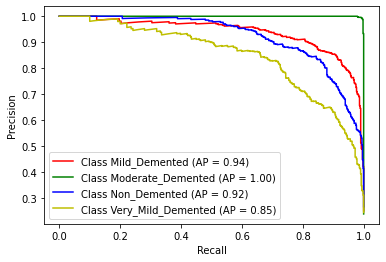

In [80]:
#Precision-recall curve for mobilenet basic model
from sklearn.metrics import precision_recall_curve, average_precision_score
avg_precisions = []
for i in range(4):
    avg_precisions.append(average_precision_score(test_labels[:, i], predictions[:, i]))
precisions = []
recalls = []
for i in range(4):
    precision, recall, _ = precision_recall_curve(test_labels[:, i], predictions[:, i])
    precisions.append(precision)
    recalls.append(recall)
fig, ax = plt.subplots()
colors = ["r", "g", "b", "y"]
for i in range(len(test_labels[0])):
    ax.plot(recalls[i], precisions[i], label="Class {} (AP = {:.2f})".format(classnames[i], avg_precisions[i]), color=colors[i])
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()
plt.show()


In [8]:
#Importing the pre-trained InceptionV3 from keras
from tensorflow.keras.applications.inception_v3 import InceptionV3
inception_model = InceptionV3(input_shape=(180, 180, 3), include_top=False, weights="imagenet")

In [9]:
#Freezing the weights of the pre-trained model
for layer in inception_model.layers:
    layer.trainable=False

In [10]:
#Adding necessary layers
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D
my_inception_model = Sequential([
        inception_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')        
    ])

In [12]:
#Compiling the model
my_inception_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=["accuracy"])

In [13]:
#Training the model for 20 epochs
hist = my_inception_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=30)

Epoch 1/30
205/205 [==============================] - 441s 2s/step - loss: 1.2991 - accuracy: 0.4522 - val_loss: 0.7918 - val_accuracy: 0.6473
Epoch 2/30
205/205 [==============================] - 357s 2s/step - loss: 0.9091 - accuracy: 0.5832 - val_loss: 0.6665 - val_accuracy: 0.6827
Epoch 3/30
205/205 [==============================] - 388s 2s/step - loss: 0.7779 - accuracy: 0.6368 - val_loss: 0.6189 - val_accuracy: 0.7224
Epoch 4/30
205/205 [==============================] - 376s 2s/step - loss: 0.7152 - accuracy: 0.6731 - val_loss: 0.5811 - val_accuracy: 0.7322
Epoch 5/30
205/205 [==============================] - 367s 2s/step - loss: 0.6739 - accuracy: 0.6953 - val_loss: 0.5455 - val_accuracy: 0.7547
Epoch 6/30
205/205 [==============================] - 391s 2s/step - loss: 0.6406 - accuracy: 0.7206 - val_loss: 0.5257 - val_accuracy: 0.7627
Epoch 7/30
205/205 [==============================] - 355s 2s/step - loss: 0.6047 - accuracy: 0.7357 - val_loss: 0.4806 - val_accuracy: 0.7901

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Maithri\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Maithri\AppData\Local\Temp/ipykernel_12008/2727985748.py", line 1, in <module>
    hist = my_inception_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=30)
  File "C:\Users\Maithri\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "C:\Users\Maithri\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1685, in fit
    tmp_logs = self.train_function(iterator)
  File "C:\Users\Maithri\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\util\traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "C:\Users\Maithri\AppData\Roaming\Python\Python39\site-packages\tensorflo

TypeError: object of type 'NoneType' has no len()

In [18]:
loss, accuracy = my_inception_model.evaluate(test_data,test_labels)

64/64 [==============================] - 183s 2s/step - loss: 0.3706 - accuracy: 0.8447


In [16]:
my_inception_model.save('model_inception_4.h5')

In [81]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('model_inception_4.h5')

In [82]:
predictions = model.predict(test_data)

64/64 [==============================] - 82s 1s/step


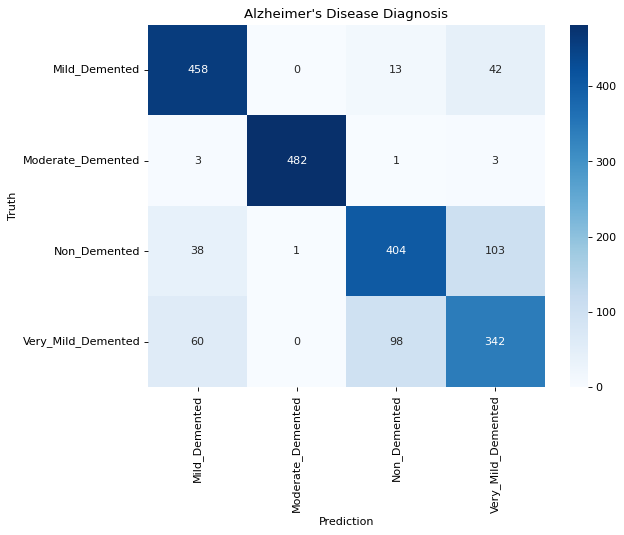

In [41]:
#Confusion matrix for inception basic model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

pred_ls = np.argmax(predictions, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Blues', annot=True, fmt='d', xticklabels= classnames,
                yticklabels=classnames)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

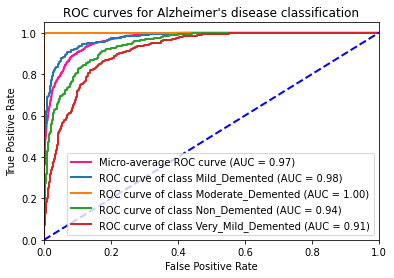

In [83]:
#ROC curve for inception basic model
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], color="deeppink", lw=lw, label="Micro-average ROC curve (AUC = {0:0.2f})".format(roc_auc["micro"]))
for i in range(4):
    plt.plot(fpr[i], tpr[i], lw=lw, label="ROC curve of class {0} (AUC = {1:0.2f})".format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], color="b", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves for Alzheimer's disease classification")
plt.legend(loc="lower right")
plt.show()

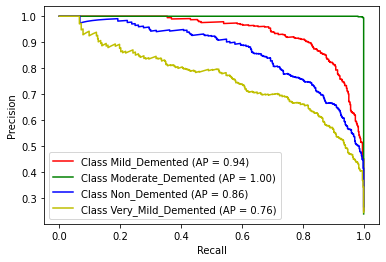

In [84]:
#Precision-recall curve for inception basic model
from sklearn.metrics import precision_recall_curve, average_precision_score
avg_precisions = []
for i in range(4):
    avg_precisions.append(average_precision_score(test_labels[:, i], predictions[:, i]))
precisions = []
recalls = []
for i in range(4):
    precision, recall, _ = precision_recall_curve(test_labels[:, i], predictions[:, i])
    precisions.append(precision)
    recalls.append(recall)
fig, ax = plt.subplots()
colors = ["r", "g", "b", "y"]
for i in range(len(test_labels[0])):
    ax.plot(recalls[i], precisions[i], label="Class {} (AP = {:.2f})".format(classnames[i], avg_precisions[i]), color=colors[i])
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()
plt.show()
